<a href="https://colab.research.google.com/github/rafatb/Berlin_Airbnb_Price_Prediction/blob/main/5_Airbnb_Berlin_Model_and_Hyperparameter_Finetuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Regressor Models and Hyperparameter Finetuning**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [51]:
!pip install -U scikit-learn

In [2]:
import matplotlib.pyplot as plt
#%matplotlib ipympl
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn.metrics as metrics
from sklearn.datasets import make_classification
#from xgboost import XGBClassifier
#!pip install xgboost scikit-learn pandas numpy
import xgboost as xgb
import warnings
warnings.filterwarnings("ignore")

#Get the data

In [3]:
df = pd.read_csv('/content/drive/MyDrive/kaggle/berline/after_feature_selection.csv')

In [5]:
df.head(5)

,Unnamed: 0,Accuracy Rating,Checkin Rating,Communication Rating,Location Rating,Value Rating,Reviews,Bedrooms,Beds,Guests Included,Instant Bookable,Is Exact Location,Postal Code,Property Type,Neighborhood Group,Room Type,Distance From Center,Price
0,0,10.0,10.0,10.0,9.0,10.0,7.0,1.0,1.0,1.0,False,True,24,1,6,1,5.1,17.0
1,1,9.0,9.0,9.0,10.0,9.0,144.0,1.0,2.0,2.0,False,True,18,1,6,0,3.7,90.0
2,2,10.0,10.0,10.0,10.0,10.0,229.0,1.0,2.0,1.0,False,True,24,1,6,1,4.6,33.0
3,3,10.0,10.0,10.0,10.0,10.0,6.0,4.0,7.0,5.0,False,False,18,1,6,0,3.5,180.0
4,4,10.0,9.0,10.0,9.0,9.0,23.0,0.0,1.0,1.0,False,True,24,1,6,0,5.0,70.0


In [6]:
#stubborn upload bug is here to stay
del df['Unnamed: 0']
#del df_ros['split']

In [7]:
df.shape

(23536, 17)

#Metrics init

In [20]:
models_list = pd.DataFrame()

In [21]:
def regressionMetrics(y, yhat):
    res = {'MSE': metrics.mean_squared_error(y,yhat),
           'RMSE': np.sqrt(metrics.mean_squared_error(y,yhat)),
           'MAE': metrics.mean_absolute_error(y,yhat),

          }
    # Calculate RMSLE using absolute values to avoid negative issues
    res['RMSLE'] = np.sqrt(metrics.mean_squared_log_error(np.abs(y), np.abs(yhat)))

    return res

In [8]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Accuracy Rating,23536.0,9.652787,0.777979,2.0,10.0,10.0,10.0,10.0
Checkin Rating,23536.0,9.717135,0.707289,2.0,10.0,10.0,10.0,10.0
Communication Rating,23536.0,9.735448,0.695917,2.0,10.0,10.0,10.0,10.0
Location Rating,23536.0,9.532843,0.763634,2.0,9.0,10.0,10.0,10.0
Value Rating,23536.0,9.391188,0.878062,2.0,9.0,10.0,10.0,10.0
Reviews,23536.0,19.238826,40.360483,0.0,1.0,5.0,17.0,545.0
Bedrooms,23536.0,1.161667,0.660499,0.0,1.0,1.0,1.0,10.0
Beds,23536.0,1.641762,1.228880,0.0,1.0,1.0,2.0,22.0
Guests Included,23536.0,1.346151,0.856297,1.0,1.0,1.0,1.0,16.0
Postal Code,23536.0,60.090755,53.656203,0.0,18.0,56.0,73.0,206.0


Display correlation and heat map

<Axes: >

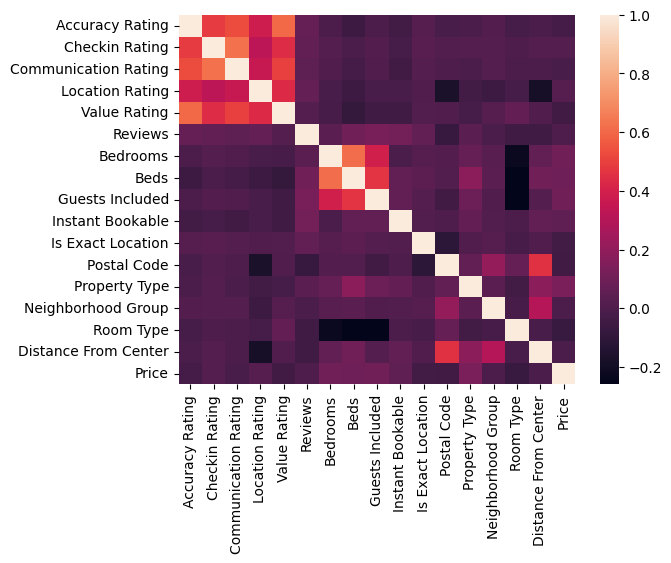

In [9]:
sns.heatmap(df.corr())

Display the correlation

In [12]:
df.corr()

,Accuracy Rating,Checkin Rating,Communication Rating,Location Rating,Value Rating,Reviews,Bedrooms,Beds,Guests Included,Instant Bookable,Is Exact Location,Postal Code,Property Type,Neighborhood Group,Room Type,Distance From Center,Price
Accuracy Rating,1.000000,0.487069,0.528905,0.380037,0.605289,0.070995,-0.006562,-0.053644,-0.003971,-0.037632,0.025279,-0.016297,-0.010501,0.015007,-0.025842,-0.013021,-0.029902
Checkin Rating,0.487069,1.000000,0.621532,0.322948,0.440097,0.059460,0.018309,-0.009922,0.015574,-0.023945,0.031248,0.006769,0.020313,0.020047,-0.002463,0.016425,0.019832
Communication Rating,0.528905,0.621532,1.000000,0.359016,0.500024,0.048549,0.003940,-0.032547,0.001305,-0.040672,0.016435,-0.003137,-0.008806,0.020207,-0.007167,-0.003913,-0.017054
Location Rating,0.380037,0.322948,0.359016,1.000000,0.430012,0.066081,-0.014613,-0.056217,-0.013748,-0.013706,0.004991,-0.166678,-0.037027,-0.061056,-0.024639,-0.182816,0.024410
Value Rating,0.605289,0.440097,0.500024,0.430012,1.000000,0.019200,-0.023149,-0.083892,-0.044786,-0.045712,0.006751,0.002756,-0.027432,0.025000,0.063520,0.001871,-0.041020
Reviews,0.070995,0.059460,0.048549,0.066081,0.019200,1.000000,0.039710,0.106012,0.127168,0.113040,0.058045,-0.077138,0.039797,-0.008697,-0.044036,-0.046744,-0.001546
Bedrooms,-0.006562,0.018309,0.003940,-0.014613,-0.023149,0.039710,1.000000,0.616095,0.390459,-0.012421,0.025732,0.012257,0.070697,0.035570,-0.225871,0.058883,0.107012
Beds,-0.053644,-0.009922,-0.032547,-0.056217,-0.083892,0.106012,0.616095,1.000000,0.465730,0.060169,0.043554,0.010940,0.180002,0.036998,-0.259591,0.104756,0.098237
Guests Included,-0.003971,0.015574,0.001305,-0.013748,-0.044786,0.127168,0.390459,0.465730,1.000000,0.060148,0.019453,-0.042822,0.089397,0.003460,-0.258283,0.018690,0.109113
Instant Bookable,-0.037632,-0.023945,-0.040672,-0.013706,-0.045712,0.113040,-0.012421,0.060169,0.060148,1.000000,0.006965,0.000905,0.064506,0.009563,-0.003844,0.059343,0.052882


#price destripution

<Axes: xlabel='Price', ylabel='Density'>

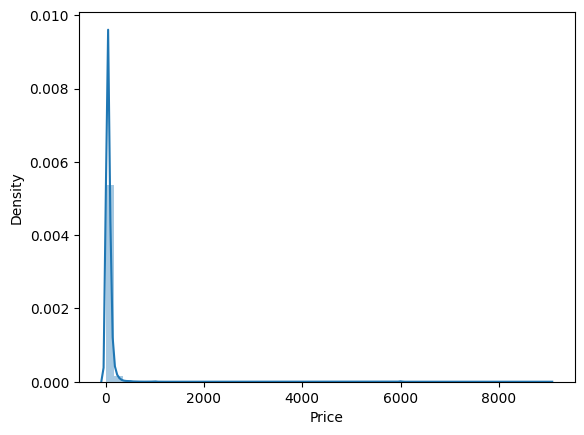

In [11]:
sns.distplot(df.Price)

In [14]:
df['Price'].max()

9000.0

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23536 entries, 0 to 23535
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Accuracy Rating       23536 non-null  float64
 1   Checkin Rating        23536 non-null  float64
 2   Communication Rating  23536 non-null  float64
 3   Location Rating       23536 non-null  float64
 4   Value Rating          23536 non-null  float64
 5   Reviews               23536 non-null  float64
 6   Bedrooms              23536 non-null  float64
 7   Beds                  23536 non-null  float64
 8   Guests Included       23536 non-null  float64
 9   Instant Bookable      23536 non-null  bool   
 10  Is Exact Location     23536 non-null  bool   
 11  Postal Code           23536 non-null  int64  
 12  Property Type         23536 non-null  int64  
 13  Neighborhood Group    23536 non-null  int64  
 14  Room Type             23536 non-null  int64  
 15  Distance From Cente

#Create and Train Regression Models

In [16]:
from sklearn.model_selection import train_test_split

y = df.Price
X = df.drop(columns=['Price'])

# Split into train+val and test sets (80% train+val, 20% test)
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Split train+val into train and val sets (75% train, 25% val from the train+val set)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.25, random_state=42
)

#Regression Models

In [17]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
#!pip install xgboost
import xgboost as xgb

##Linear Regression

In [18]:
# Create and train the model
model = LinearRegression()
model.fit(X_train, y_train)  # Use X_train and y_train

# Make predictions on the validation set
y_val_pred = model.predict(X_val)

In [22]:
regressionMetrics(y_val, y_val_pred)

{'MSE': 72736.032777503,
 'RMSE': np.float64(269.69618606406544),
 'MAE': 42.27024004109706,
 'RMSLE': np.float64(0.6669052091776113)}

In [23]:
model_dict = {'model': "Linear Regression"}
new_row = pd.DataFrame([{**model_dict, **regressionMetrics(y_val, y_val_pred)}])
models_list = pd.concat([models_list, new_row], ignore_index=True)
models_list

,model,MSE,RMSE,MAE,RMSLE
0,Linear Regression,72736.032778,269.696186,42.27024,0.666905


<Axes: xlabel='Price'>

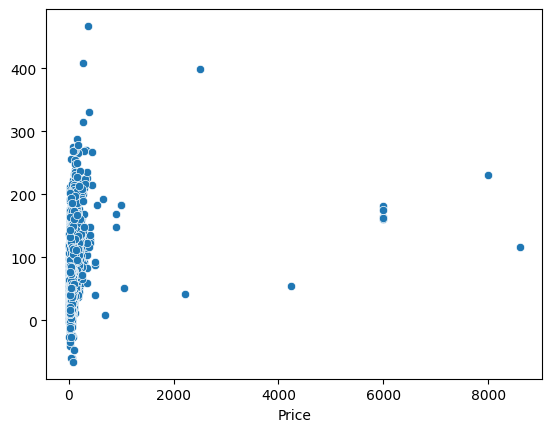

In [24]:
sns.scatterplot(x=y_val, y=y_val_pred)

##Decision Tree

In [25]:
mod2 = DecisionTreeRegressor(random_state=1)
mod2.fit(X_train, y_train)
# Make predictions on the validation set
y_val_pred2 = mod2.predict(X_val)

In [27]:
regressionMetrics(y_val, y_val_pred)

{'MSE': 72736.032777503,
 'RMSE': np.float64(269.69618606406544),
 'MAE': 42.27024004109706,
 'RMSLE': np.float64(0.6669052091776113)}

In [28]:
model_dict = {'model': "Decision Tree"}
new_row = pd.DataFrame([{**model_dict, **regressionMetrics(y_val, y_val_pred2)}])
models_list = pd.concat([models_list, new_row], ignore_index=True)
models_list


,model,MSE,RMSE,MAE,RMSLE
0,Linear Regression,72736.032778,269.696186,42.270240,0.666905
1,Decision Tree,53469.999221,231.235809,37.766022,0.607485


<Axes: xlabel='Price'>

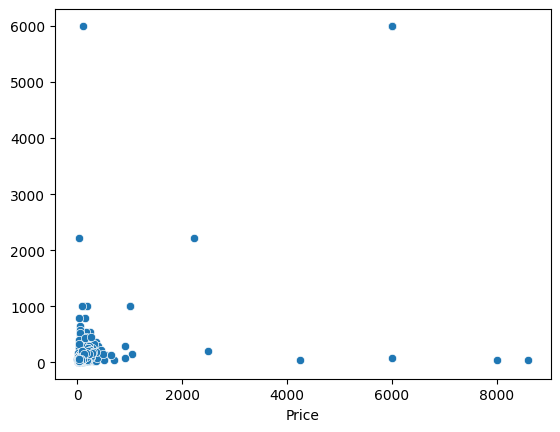

In [29]:
sns.scatterplot(x=y_val, y=y_val_pred2)

##Random Forest

In [30]:
mod3 = RandomForestRegressor(random_state=1)
mod3.fit(X_train, y_train)
# Make predictions on the validation set
y_val_pred3 = mod3.predict(X_val)

In [31]:
regressionMetrics(y_val, y_val_pred3)

{'MSE': 41633.56000081804,
 'RMSE': np.float64(204.0430346785159),
 'MAE': 31.212217456439415,
 'RMSLE': np.float64(0.4897855667741702)}

In [32]:
pred3 = mod3.predict(X)
model_dict = {'model': "RandomForest"}
new_row = pd.DataFrame([{**model_dict, **regressionMetrics(y_val, y_val_pred3)}])
models_list = pd.concat([models_list, new_row], ignore_index=True)
models_list

,model,MSE,RMSE,MAE,RMSLE
0,Linear Regression,72736.032778,269.696186,42.270240,0.666905
1,Decision Tree,53469.999221,231.235809,37.766022,0.607485
2,RandomForest,41633.560001,204.043035,31.212217,0.489786


<Axes: xlabel='Price'>

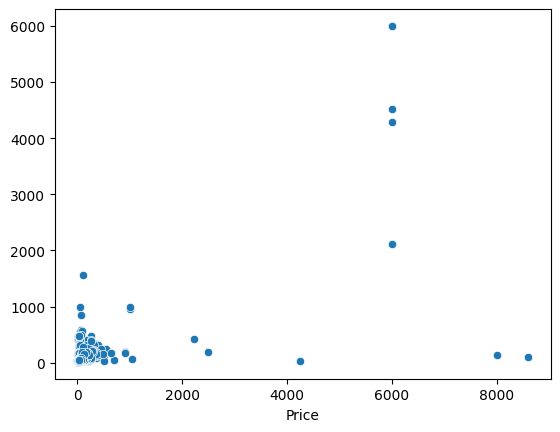

In [33]:
sns.scatterplot(x=y_val, y=y_val_pred3)

##Adaptive Boosting (ADABoost)

In [34]:
mod4 = AdaBoostRegressor(random_state=1)
mod4.fit(X_train, y_train)

AdaBoostRegressor(random_state=1)

In [35]:
# Make predictions on the validation set
y_val_pred4 = mod4.predict(X_val)

In [36]:
model_dict = {'model': "ADABoost"}
new_row = pd.DataFrame([{**model_dict, **regressionMetrics(y_val, y_val_pred4)}])
models_list = pd.concat([models_list, new_row], ignore_index=True)
models_list

,model,MSE,RMSE,MAE,RMSLE
0,Linear Regression,72736.032778,269.696186,42.270240,0.666905
1,Decision Tree,53469.999221,231.235809,37.766022,0.607485
2,RandomForest,41633.560001,204.043035,31.212217,0.489786
3,ADABoost,48319.344300,219.816615,78.713734,1.003828


<Axes: xlabel='Price'>

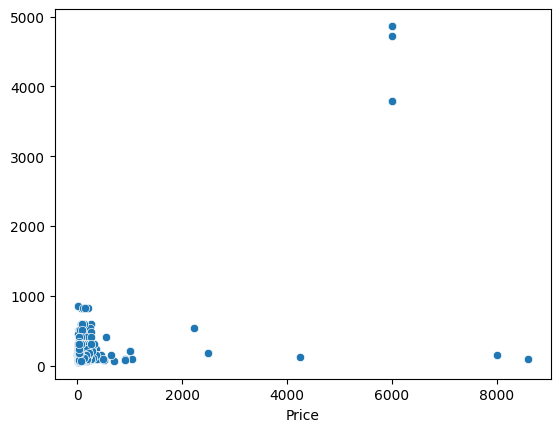

In [37]:
sns.scatterplot(x=y_val, y=y_val_pred4)

##Gradient Boosting Machine (GBM)

In [38]:
mod5 = GradientBoostingRegressor(random_state=1)
mod5.fit(X_train, y_train)

GradientBoostingRegressor(random_state=1)

In [39]:
# Make predictions on the validation set
y_val_pred5 = mod5.predict(X_val)

In [40]:
model_dict = {'model': "GBM"}
new_row = pd.DataFrame([{**model_dict, **regressionMetrics(y_val, y_val_pred5)}])
models_list = pd.concat([models_list, new_row], ignore_index=True)
models_list

,model,MSE,RMSE,MAE,RMSLE
0,Linear Regression,72736.032778,269.696186,42.270240,0.666905
1,Decision Tree,53469.999221,231.235809,37.766022,0.607485
2,RandomForest,41633.560001,204.043035,31.212217,0.489786
3,ADABoost,48319.344300,219.816615,78.713734,1.003828
4,GBM,49735.649292,223.014908,34.511307,0.527770


<Axes: xlabel='Price'>

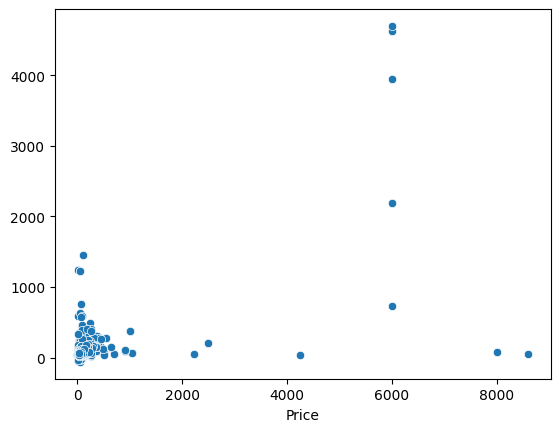

In [41]:
sns.scatterplot(x=y_val, y=y_val_pred5)

##Support Vector Machine (SVM)

In [42]:
mod6 = SVR()
mod6.fit(X_train, y_train)
# Make predictions on the validation set
y_val_pred6 = mod6.predict(X_val)

In [43]:
model_dict = {'model': "SVM"}
new_row = pd.DataFrame([{**model_dict, **regressionMetrics(y_val,y_val_pred6)}])
models_list = pd.concat([models_list, new_row], ignore_index=True)
models_list

,model,MSE,RMSE,MAE,RMSLE
0,Linear Regression,72736.032778,269.696186,42.270240,0.666905
1,Decision Tree,53469.999221,231.235809,37.766022,0.607485
2,RandomForest,41633.560001,204.043035,31.212217,0.489786
3,ADABoost,48319.344300,219.816615,78.713734,1.003828
4,GBM,49735.649292,223.014908,34.511307,0.527770
5,SVM,75655.951171,275.056269,39.868419,0.604483


<Axes: xlabel='Price'>

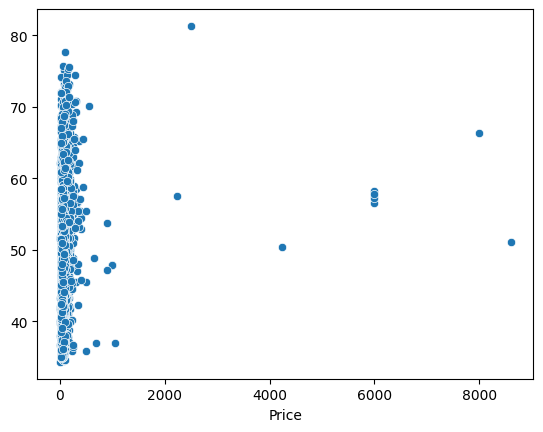

In [44]:
sns.scatterplot(x=y_val, y=y_val_pred6)

##XGBoost Regressor

In [45]:
mod7= xgb.XGBRegressor()
mod7.fit(X_train, y_train)
# Make predictions on the validation set
y_val_pred7 = mod7.predict(X_val)

In [46]:
model_dict = {'model': "XGB"}
new_row = pd.DataFrame([{**model_dict, **regressionMetrics(y_val,y_val_pred7)}])
models_list = pd.concat([models_list, new_row], ignore_index=True)
models_list

,model,MSE,RMSE,MAE,RMSLE
0,Linear Regression,72736.032778,269.696186,42.270240,0.666905
1,Decision Tree,53469.999221,231.235809,37.766022,0.607485
2,RandomForest,41633.560001,204.043035,31.212217,0.489786
3,ADABoost,48319.344300,219.816615,78.713734,1.003828
4,GBM,49735.649292,223.014908,34.511307,0.527770
5,SVM,75655.951171,275.056269,39.868419,0.604483
6,XGB,42474.709782,206.093934,31.574877,0.512779


<Axes: xlabel='Price'>

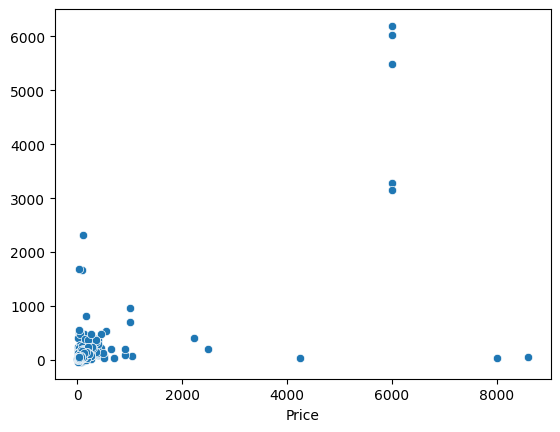

In [47]:
sns.scatterplot(x=y_val, y=y_val_pred7)

## Model Selection

Metrics:<br><b>MSE</b> - Mean Squared Error<br><b>RMSE</b> Root Mean Squared Error<br><b>MAE </b>Mean Absolute Error Calculates the average of the absolute differences between predicted and actual values.<br>
<b>RMSLE</b> Root Mean Squared Logarithmic Error

In [48]:
models_list.sort_values('MAE')

,model,MSE,RMSE,MAE,RMSLE
2,RandomForest,41633.560001,204.043035,31.212217,0.489786
6,XGB,42474.709782,206.093934,31.574877,0.512779
4,GBM,49735.649292,223.014908,34.511307,0.527770
1,Decision Tree,53469.999221,231.235809,37.766022,0.607485
5,SVM,75655.951171,275.056269,39.868419,0.604483
0,Linear Regression,72736.032778,269.696186,42.270240,0.666905
3,ADABoost,48319.344300,219.816615,78.713734,1.003828


# Hyperparameters and Finetuning

In [53]:
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV

# Random Search: we decide which parameters and how (randomly)

In [54]:
# Reduced number of options for each hyperparameter
n_estimators = [100, 200, 300]  # Fewer values for the number of trees
max_features = ['auto','sqrt']  #  # Number of features to consider at each split
max_depth = [10, 20, 30, 40, None]  # Fewer values for max depth
min_samples_split = [2, 5, 10]  # Keep essential options only
min_samples_leaf = [1, 2, 4]  # Reduced options for leaf samples
bootstrap = [True, False]  # Keep as is

# Create a lighter random grid
lighter_grid = {
    'n_estimators': n_estimators,
    'max_features': max_features,
    'max_depth': max_depth,
    'min_samples_split': min_samples_split,
    'min_samples_leaf': min_samples_leaf,
    'bootstrap': bootstrap
}

print(lighter_grid)

# Reduced number of iterations and cross-validation folds
rf_random = RandomizedSearchCV(estimator=mod3, param_distributions=lighter_grid, n_iter=25, cv=3,
                               verbose=2, random_state=42, n_jobs=-1)

# Fit the random search model
rf_random.fit(X_train, y_train)

{'n_estimators': [100, 200, 300], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}
Fitting 3 folds for each of 25 candidates, totalling 75 fits


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(random_state=1),
                   n_iter=25, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 200, 300]},
                   random_state=42, verbose=2)

In [55]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mae = 100 * np.mean(errors)
    print('Model Performance')
    print('Mean Absolute Error: {:0.4f}'.format(np.mean(errors)))
    return mae

#Running base Model

In [56]:
base_model = RandomForestRegressor(n_estimators = 100, random_state = 4)
base_model.fit(X_train, y_train)
base_accuracy = evaluate(base_model, X_test, y_test)

Model Performance
Mean Absolute Error: 27.4651


In [57]:
best_random = rf_random.best_estimator_
random_accuracy = evaluate(best_random, X_test, y_test)

Model Performance
Mean Absolute Error: 26.7387


In [58]:
print('Improvement of {:0.2f}%.'.format( 100 * (base_accuracy - random_accuracy) / base_accuracy))

Improvement of 2.64%.


## Conclusion

In [ ]:
There is tiny Improvment of 2.64% from on Finetuning, we will use the new hyperparams.